# Simulator Runtime Analysis
## Summary of what the plot has showed us:
* **JAX is consistently fastest**
  Across every resolution *N* and every integration-step count, the JAX curve sits at least an **order of magnitude** lower than NumPy and well below PyTorch.
  *Implication:* For long production runs, JAX should be the default backend.

* **PyTorch overtakes NumPy for larger grids**
  The speed-up bars show **Torch / NumPy < 1** once *N* ≥ 80, dropping to roughly **0.5×** NumPy at *N* = 320.
  *Implication:* GPU kernel fusion amortises launch cost at high spectral resolution; on small grids NumPy’s low overhead is still competitive.

* **Runtime scales linearly with the number of integration steps**
  Log-log “runtime vs steps” lines have slope ≈ 1 for all backends, meaning doubling the simulated time (or halving Δt) doubles wall-time.
  *Implication:* Timestep choices dominate wall-time once the backend is fixed.

* **NumPy’s cost explodes with *N***
  Mean runtime rises ≈ 14 × from *N* = 40 to 320, while JAX rises only ≈ 3 ×.
  *Implication:* CPU cache misses hurt far more than GPU memory bandwidth as matrix size grows.

* **Memory, not runtime, becomes the limit at large *N***
  The QTF tensor size grows as **O(*N*²)**; doubling *N* quadruples required RAM/VRAM.
  *Implication:* Above *N* ≈ 400 you’ll likely hit GPU memory ceilings before runtime is the bottleneck—consider block-wise evaluation or reduced-order models.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('./src_speed/speed_compare.csv')
df['steps'] = df['simtime'] / df['dt']
print(df.head())

    N    dt  simtime  jax_time  numpy_time  torch_time   steps
0  40  0.10       40  0.048516    0.297253    0.463926   400.0
1  40  0.10       80  0.096002    0.784360    0.967235   800.0
2  40  0.10      160  0.232944    1.362875    1.588256  1600.0
3  40  0.10      320  0.313499    2.324274    3.203523  3200.0
4  40  0.05       40  0.099548    1.005916    0.841340   800.0


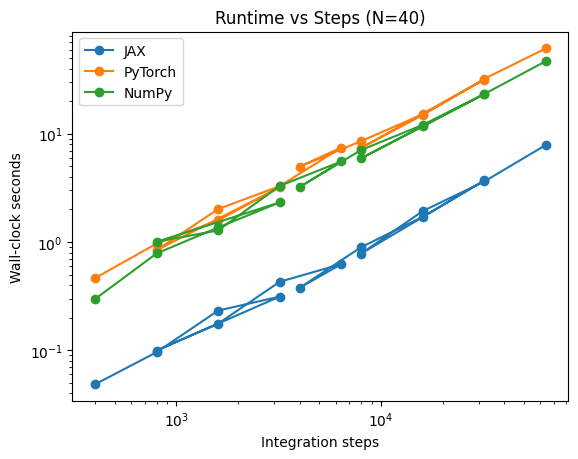

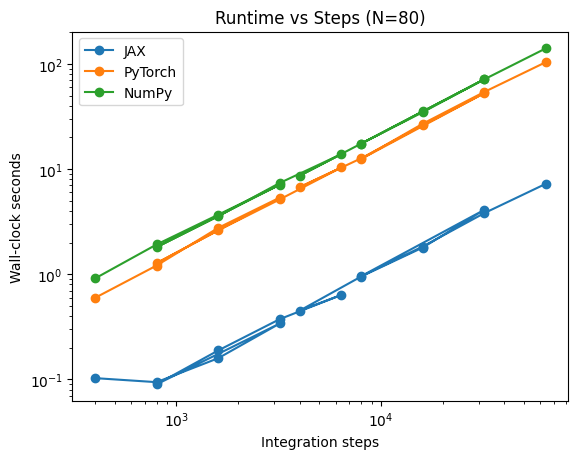

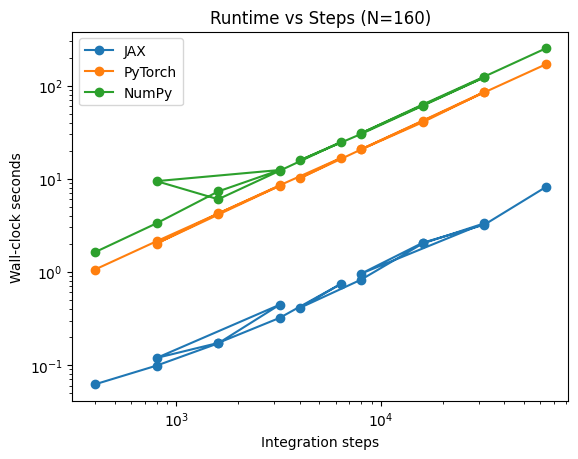

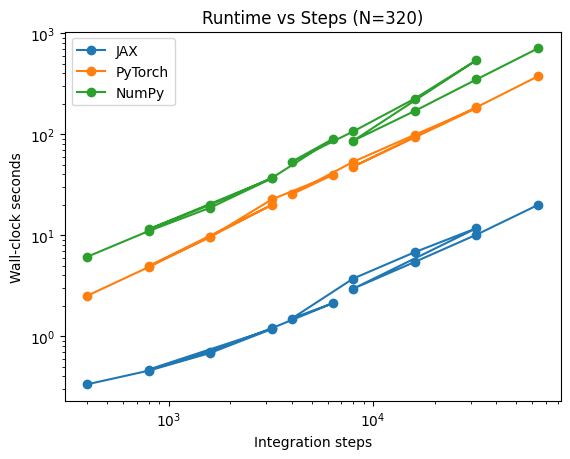

In [7]:
for N, g in df.groupby('N'):
    fig, ax = plt.subplots()
    for backend, label in [('jax_time','JAX'),('torch_time','PyTorch'),('numpy_time','NumPy')]:
        ax.plot(g['steps'], g[backend], label=label, marker='o')
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_title(f'Runtime vs Steps (N={N})')
    ax.set_xlabel('Integration steps'); ax.set_ylabel('Wall-clock seconds'); ax.legend()
    plt.show()


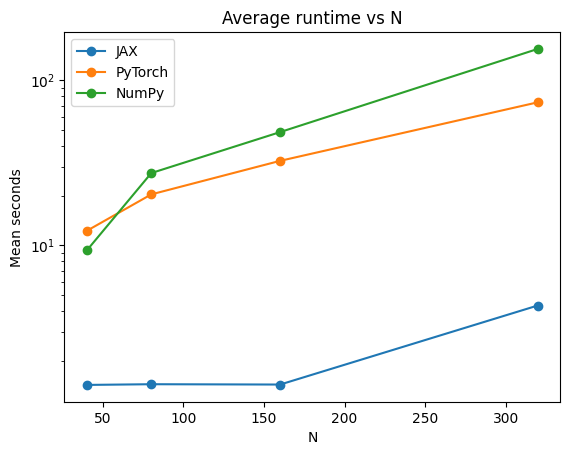

In [8]:
mean_runtime = df.groupby('N')[['jax_time','numpy_time','torch_time']].mean()
fig, ax = plt.subplots()
for col,label in [('jax_time','JAX'),('torch_time','PyTorch'),('numpy_time','NumPy')]:
    ax.plot(mean_runtime.index, mean_runtime[col], marker='o', label=label)
ax.set_yscale('log'); ax.set_title('Average runtime vs N'); ax.set_xlabel('N'); ax.set_ylabel('Mean seconds'); ax.legend(); plt.show()


/tmp/ipykernel_110887/3261245441.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratio_torch_numpy = df.groupby('N').apply(lambda d: d['torch_time'].sum() / d['numpy_time'].sum())
/tmp/ipykernel_110887/3261245441.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratio_jax_numpy = df.groupby('N').apply(lambda d: d['jax_time'].sum() / d['numpy_time'].sum())


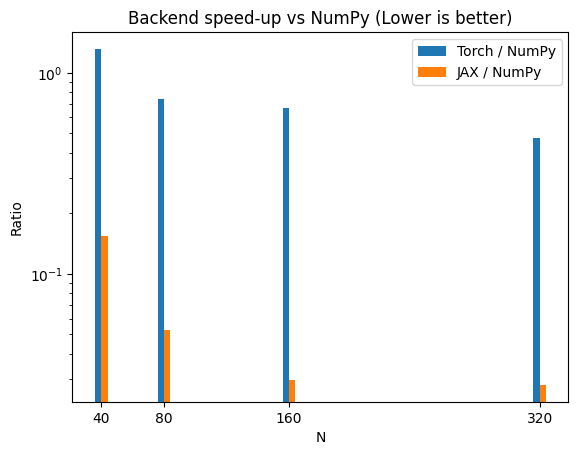

In [9]:
ratio_torch_numpy = df.groupby('N').apply(lambda d: d['torch_time'].sum() / d['numpy_time'].sum())
ratio_jax_numpy = df.groupby('N').apply(lambda d: d['jax_time'].sum() / d['numpy_time'].sum())
fig, ax = plt.subplots()
ax.bar(ratio_torch_numpy.index - 2, ratio_torch_numpy.values, width=4, label='Torch / NumPy')
ax.bar(ratio_jax_numpy.index + 2, ratio_jax_numpy.values, width=4, label='JAX / NumPy')
ax.set_yscale('log'); ax.set_title('Backend speed-up vs NumPy (Lower is better)'); ax.set_xlabel('N'); ax.set_ylabel('Ratio'); ax.set_xticks(ratio_torch_numpy.index); ax.legend(); plt.show()


## Memory considerations
For a QTF tensor $\mathcal{Q}\in \mathbb{R}^{6\times M \times N \times N}$ memory grows quadratically with $N$; doubling $N$ quadruples GPU memory requirements.